In [1]:
import sys
sys.version

'3.7.0b3 (default, Mar 30 2018, 04:35:22) \n[GCC 7.3.0]'

In [2]:
import numpy as np
import gym, math
from tqdm import trange
from buffer import ReplayBuffer, Transition
from agent import Agent
from env import FrameStack1D

%load_ext autoreload
%autoreload 2

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib notebook

def plot(rewards, prior, term):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title(f"last reward: {rewards[-1]}")
    plt.plot(rewards)
    plt.subplot(132)
    plt.title("priority")
    plt.plot(prior)
    plt.plot(term, alpha=0.5)
    plt.show()

In [4]:
beta_start  = 0.4
beta_frames = 1000 
beta_by_frame = lambda frame_idx: min(1.0, beta_start + frame_idx * (1.0 - beta_start) / beta_frames)

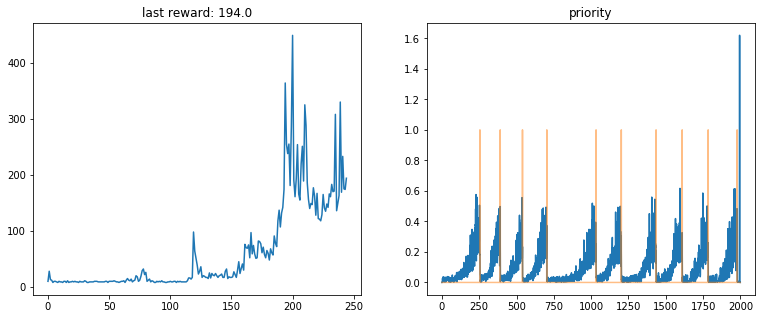

100%|██████████| 15000/15000 [01:42<00:00, 146.27it/s]


In [5]:
batch_size = 32
history = 4
env = FrameStack1D(gym.make("CartPole-v1"), history)
buffer = ReplayBuffer(2000, history=history, alpha=0.5)
agent = Agent(env.observation_space.shape[0], env.action_space.n, history=history, lr=0.0005, batch_size=batch_size, atoms=11)

all_rewards = []
episode_reward = 0
state = env.reset()

for frame_idx in trange(15000):
    agent.sample_noise()
    buffer.beta = beta_by_frame(frame_idx)
    action = agent.act(state)
    next_state, reward, terminal, _ = env.step(action)
    buffer.append(Transition(state[-1], action, reward, terminal))
    state = next_state
    episode_reward += reward
    
    if terminal:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if buffer.can_sample(batch_size):
        agent.learn(buffer)

    if (frame_idx + 1) % 500 == 0:
        term = list(map(lambda t: int(t.terminal), buffer._buffer))
        plot(all_rewards, list(buffer._prior), term)

    if (frame_idx + 1) % 100 == 0: agent.update_target_net()

In [7]:
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash xvfb start
    %env DISPLAY=:1

Starting virtual X frame buffer: Xvfb.
env: DISPLAY=:1


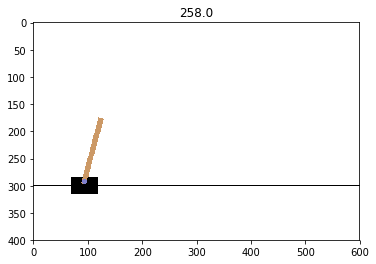

258.0


In [8]:
import time
env = FrameStack1D(gym.make("CartPole-v1"), history)
state = env.reset()
agent.eval()
episode_reward = 0
for _ in range(10000):
    action = agent.act(state)
    state, reward, done, _ = env.step(action)
    episode_reward += reward
    
    clear_output(True)
    plt.title(episode_reward)
    plt.imshow(env.render('rgb_array'))
    plt.show()

    if done: break
print(episode_reward)